# Figures pour le papier Digital Twins

In [1]:
from snake_ai.envs import RandomObstaclesEnv
import scipy.sparse as sp
import numpy as np
import phi.flow as pf
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splinalg
import tqdm

pygame 2.4.0 (SDL 2.26.5, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.11


[I 05/03/24 10:34:09.573 920] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Définition des différences finies

In [2]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")


def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [3]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

In [4]:
def apply_dirichlet_2D(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
    """
    res = binary_map.shape
    max_index = np.prod(res)
    rhs = np.zeros(max_index)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols = np.nonzero(binary_map)   
    for i, j in tqdm.tqdm(zip(rows, cols), total=len(rows)):
        index = sub2ind_2D(res, i, j)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j]
        
        ind_o = sub2ind_2D(res, i + 1, j)
        ind_e = sub2ind_2D(res, i - 1, j)
        ind_n = sub2ind_2D(res, i, j + 1)
        ind_s = sub2ind_2D(res, i, j - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs

## Utilisation d'environements existants

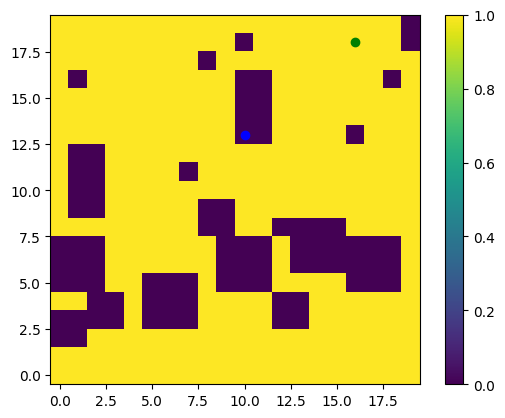

In [6]:
env = RandomObstaclesEnv(pixel=1, nb_obs=20, max_obs_size=3)
env.reset()
plt.imshow(env._free_position_mask, origin='lower')
plt.plot(env.goal.x, env.goal.y, 'go')
plt.plot(env.agent.position.x, env.agent.position.y, 'bo')
plt.colorbar()

# Definition d'environement à partir de carte binaires 

In [36]:
binary_map = np.array([
    [0, 0,0,0,0,0,0,0,0,0, 0],
    [0, 0,0,0,0,0,0,0,0,0, 0],
    [0, 0,1,1,1,0,1,1,1,0, 0],
    [0, 0,1,1,1,0,0,0,1,0, 0],
    [0, 0,1,1,1,1,1,0,1,0, 0],
    [0, 0,1,0,0,0,0,0,1,0, 0],
    [0, 0,1,0,1,1,1,1,1,0, 0],
    [0, 0,1,0,0,0,1,1,1,0, 0],
    [0, 0,1,1,1,0,1,1,1,0, 0],
    [0, 0,0,0,0,0,0,0,0,0, 0],
    [0, 0,0,0,0,0,0,0,0,0, 0],
])
binary_map.shape
x_max, y_max = binary_map.shape

<Figure size 1200x500 with 1 Axes>

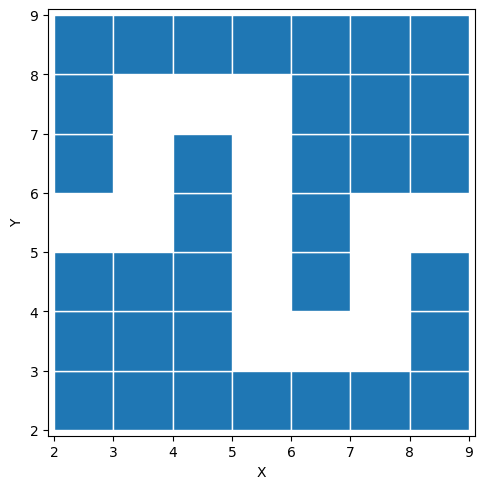

In [18]:
# Use phiflow to represent the domain
domain = pf.Box(x=binary_map.shape[0], y=binary_map.shape[1])
obstacles = [
    pf.Box(x=(i,i+1), y=(j,j+1))
    for i, j in zip(*np.where(binary_map == 1))
]
obstacle_mask = pf.union(obstacles)
pf.vis.plot(obstacle_mask)

<Figure size 1200x500 with 3 Axes>

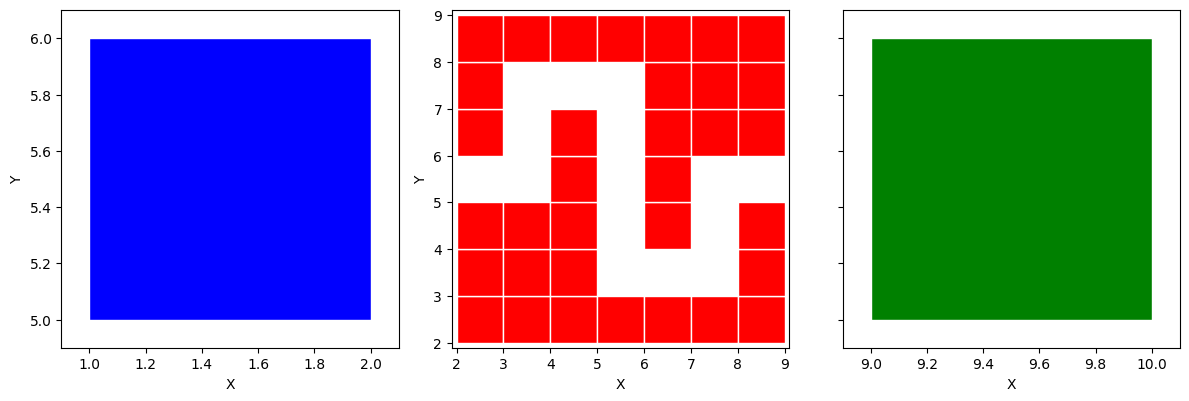

In [27]:
goal_pos = np.array([9, 5]) 
goal = pf.Box(x=(goal_pos[0], goal_pos[0]+1), y=(goal_pos[1], goal_pos[1]+1))
init_pos = np.array([1, 5])
init = pf.Box(x=(init_pos[0], init_pos[0]+1), y=(init_pos[1], init_pos[1]+1))
pf.vis.plot([init, obstacle_mask, goal], color=['blue', 'red','green'])

In [ ]:
def solve_diffusion(domain, obstacle_map, goal, resolution=1):    
    # Create the laplacian matrix
    A = create_laplacian_matrix_2d(domain.x.res, domain.y.res, domain.dx, domain.dy)
    A, rhs = apply_dirichlet_2D(A, binary_map)
    # Solve the linear system
    solution = splinalg.spsolve(A, rhs)
    # Reshape the solution to the domain shape
    solution = solution.reshape(domain.shape)
    return solution

In [8]:
res = 10
x_max, y_max = binary_map.shape

new_obs_map = np.zeros((x_max * res, y_max * res))
for x, y in np.argwhere(binary_map):
    new_obs_map[x*res:(x+1)*res, y*res:(y+1)*res] = 1

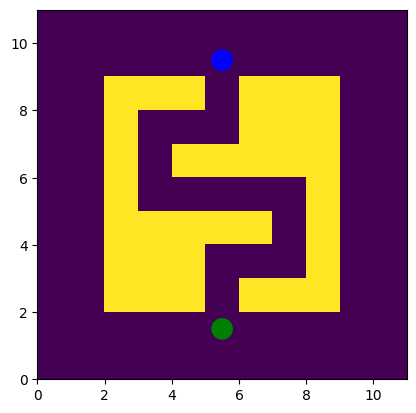

In [9]:
init_pos = np.array([5.5, 1.5])
goal_pos = np.array([5.5, 9.5])
fig, ax = plt.subplots()
ax.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])
ax.add_patch(plt.Circle(init_pos, 0.3, color="green"))
ax.add_patch(plt.Circle(goal_pos, 0.3, color="blue"))   

100%|██████████| 1/1 [00:00<00:00, 768.33it/s]


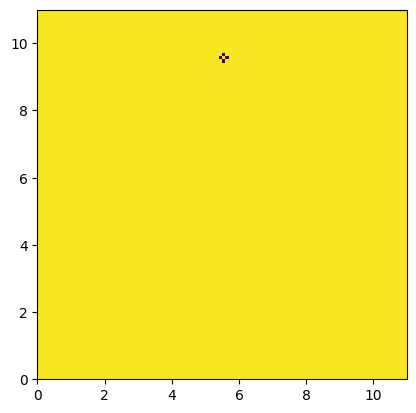

In [11]:
## 
step = np.array(binary_map.shape) / np.array(new_obs_map.shape)
laplace = create_laplacian_matrix_2d(*new_obs_map.shape, *step)
rhs = np.zeros(new_obs_map.shape)
goal_ind = goal_pos * res
rhs[int(goal_ind[1]), int(goal_ind[0])] = 1e3
laplace, rhs = apply_dirichlet_2D(laplace, rhs)
plt.imshow(rhs.reshape(new_obs_map.shape), origin='lower', extent=[0, x_max, 0, y_max])
# plt.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])

In [41]:
valid_ind = new_obs_map.flat == 0
A = laplace[valid_ind][:, valid_ind]
b = rhs.flat[valid_ind]
x = splinalg.spsolve(A, b)
solution = np.zeros(new_obs_map.shape)
solution.flat[valid_ind] = x

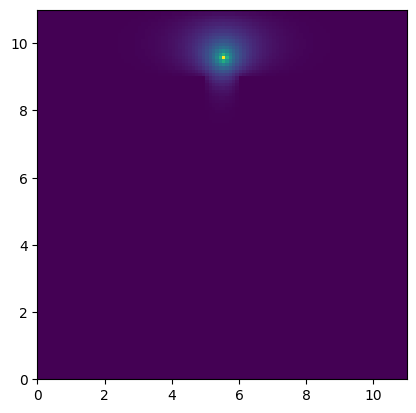

In [42]:
plt.imshow(solution, origin='lower', extent=[0, x_max, 0, y_max])

In [39]:
# Show the solution and its normalised gradient
from snake_ai.diffsim.field import ScalarField, VectorField, spatial_gradient
from snake_ai.envs.geometry import Rectangle
import taichi as ti

ti.init()
concentration = ScalarField(solution, Rectangle(0, 0, x_max, y_max))
gradient = spatial_gradient(concentration)
gradient.normalize()

[Taichi] Starting on arch=x64
